In [1]:
import math
import sys

import IPython
import IPython.display as ipd
import matplotlib.pylab as plt
import numpy as np
import pandas as pd

%reload_ext autoreload
%autoreload 2

%matplotlib inline
#%matplotlib notebook

from matplotlib import rcParams
rcParams["figure.max_open_warning"] = False

# Calibration

In [2]:
from wall_analysis import parse_calibration_experiments

fname = 'results/calibration.pkl'

try:
    df_total = pd.read_pickle(fname)
    print('read', fname)
except:
    print('could not read', fname)
    df_total = parse_calibration_experiments()
    pd.to_pickle(df_total, fname)
    print('saved as', fname)

read results/calibration.pkl


In [3]:
print(df_total.appendix.unique())
df_total.loc[df_total.appendix=='_HALL3ok', 'appendix'] = '_HALL3'
print(df_total.appendix.unique())
df_total.tail()

['' '_BC329' '_HALL' '_HALL2' '_HALL3' '_HALL3ok']
['' '_BC329' '_HALL' '_HALL2' '_HALL3']


,signals_f,source,snr,motors,exp_name,appendix,seconds,frequencies,frequencies_matrix
12,"[[[(-0.004020932-0.0014405241j), (0.0024808329...",sweep_buzzer,1,0,2020_12_11_calibration,,"[0.0, 0.117, 0.239, 0.348, 0.464, 0.583, 0.699...","[3000.0, 4000.0, 3015.0, 2671.0, 1015.0, 4015....","[[3000.0, 4000.0, 3015.0, 2671.0, 1015.0, 4015..."
13,"[[[(-0.0023182218+0.0018430655j), (0.002171850...",sweep_buzzer,1,0,2020_12_11_calibration,_BC329,"[0.0, 0.117, 0.233, 0.352, 0.467, 0.588, 0.709...","[4000.0, 3000.0, 4015.0, 3015.0, 1000.0, 1203....","[[4000.0, 3000.0, 4015.0, 3015.0, 1000.0, 1203..."
14,"[[[(0.0014276297-0.007704344j), (0.0008620804-...",sweep_buzzer,1,0,2020_12_11_calibration,_HALL,"[0.0, 0.111, 0.228, 0.346, 0.461, 0.578, 0.695...","[1078.0, 1328.0, 1015.0, 1375.0, 1234.0, 1343....","[[1078.0, 1328.0, 1015.0, 1375.0, 1234.0, 1343..."
15,"[[[(0.020320026+0.009814884j), (0.027319852-0....",sweep_buzzer,1,0,2020_12_11_calibration,_HALL2,"[0.0, 0.115, 0.232, 0.35, 0.466, 0.583, 0.702,...","[1578.0, 2093.0, 1546.0, 2750.0, 2781.0, 2500....","[[1578.0, 2093.0, 1546.0, 2750.0, 2781.0, 2500..."
16,"[[[(0.0062533272-0.003908078j), (-0.0013789814...",sweep_buzzer,1,0,2020_12_11_calibration,_HALL3,"[0.0, 0.108, 0.225, 0.342, 0.462, 0.575, 0.693...","[1171.0, 1125.0, 1078.0, 1140.0, 1359.0, 1062....","[[1171.0, 1125.0, 1078.0, 1140.0, 1359.0, 1062..."


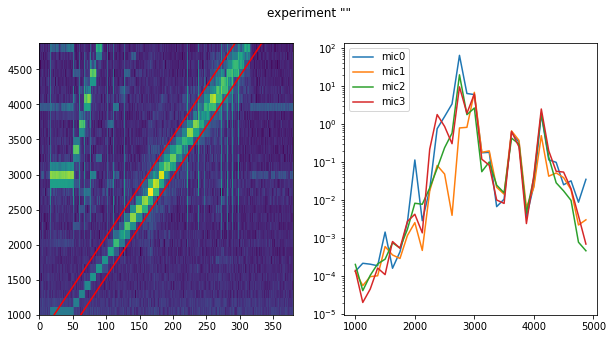

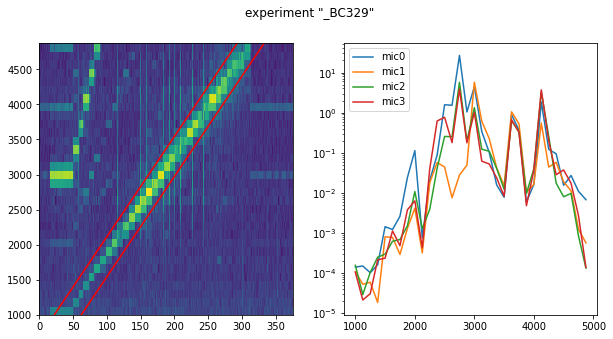

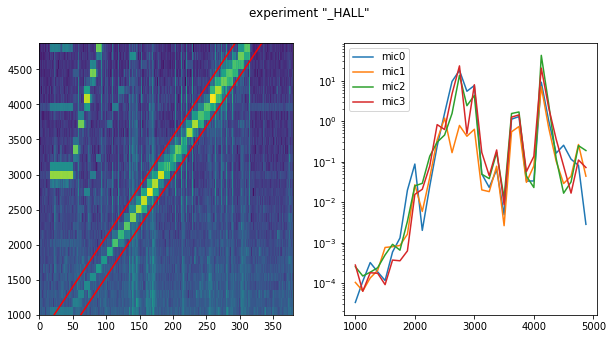

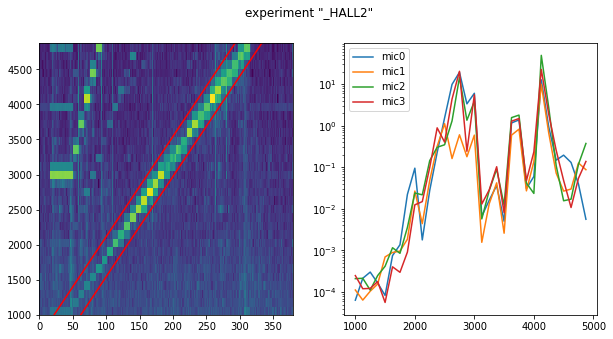

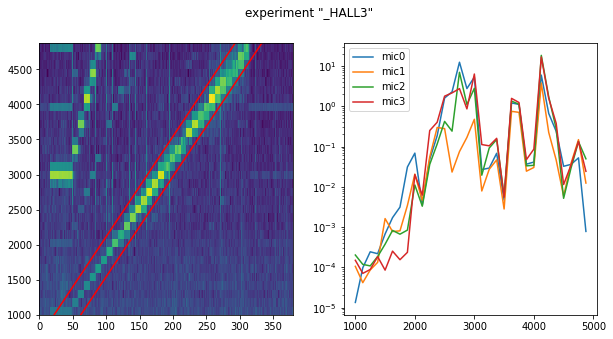

In [4]:
# calculate psd for sweep without snr selection
from wall_analysis import filter_by_dicts, extract_linear_psd

dict_chosen = [{
    'snr': 0,
    'motors': 0,
    'source': 'sweep',
}]

# found visually from spectrogram: 
sweep_lines = dict(
    slope=4000/280,
    offset=400,
    delta=20,
)

df_chosen = filter_by_dicts(df_total, dict_chosen)
for j, row in df_chosen.iterrows():
    spec = np.sum(np.abs(row.signals_f), axis=1) # sum over all mics

    fig, axs  = plt.subplots(1, 2)
    fig.set_size_inches(10, 5)
    fig.suptitle(f'experiment "{row.appendix}"')
    axs[0].pcolorfast(range(spec.shape[0]), row.frequencies, np.log10(spec.T))
    psd = extract_linear_psd(row.signals_f, row.frequencies, ax=axs[0], **sweep_lines)

    for i in range(psd.shape[0]):
        axs[1].semilogy(row.frequencies, psd[i], label=f'mic{i}')
    plt.legend(loc='upper left')

In [5]:
from wall_analysis import extract_psd, extract_psd_dict
psd_dict1 = [{0: [], 100:[1, 2, 3], 200:[0, 4, 5]}, {100:[0, 1], 200:[1, 2]}]
psd_dict2 = [{100:[1, 2, 5], 250:[1, 4, 5]}, {100:[0, 1], 250:[3, 4]}]
psd_dict_list = [psd_dict1, psd_dict2]
psd, frequencies, psd_std = extract_psd(psd_dict_list)
print(psd.shape)
print(psd, frequencies)

(2, 3)
[[2.  4.  4. ]
 [0.5 1.5 3.5]] [100 200 250]


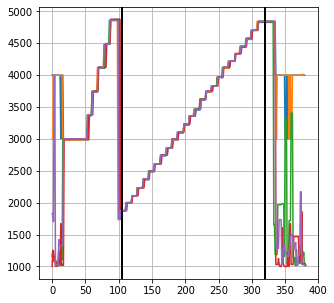

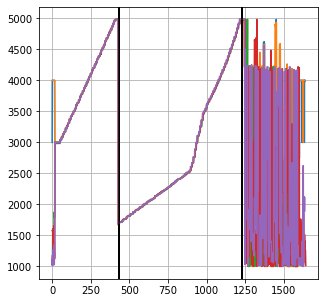

In [6]:
# calculate psd for sweep without snr selection
from wall_analysis import filter_by_dicts

n_freq = 1

dict_chosen = [{
    'snr': 1,
    'motors': 0,
}]

#from crazyflie_description_py.parameters import N_BUFFER, FS
#all_frequencies = list(np.round(np.fft.rfftfreq(N_BUFFER, 1/FS)))
#print(all_frequencies)

kwargs = {
    'sweep': {
        'min_t': 105,
        'max_t': 320,
        'n_freq': n_freq
    },
    'sweep_buzzer': {
        'min_t': 430,
        'max_t': 1230,
        'n_freq': n_freq
    }
}

# need this to assign list to this columns
df_total = df_total.assign(psd_dict=None)

df_chosen = filter_by_dicts(df_total, dict_chosen)
for (source, motors), df in df_chosen.groupby(['source', 'motors']):
    fig, ax  = plt.subplots()
    fig.set_size_inches(5, 5)
    ax.grid(which='both')
    legend = []
    for j, row in df.iterrows():
        psd_dict = extract_psd_dict(row.signals_f, row.frequencies_matrix, ax=ax, **kwargs[source])
        df_total.loc[j, 'psd_dict'] = psd_dict
        legend.append(row.appendix)

In [ ]:
kwargs_harmonics = {
    'sweep': {
        'min_t': 40,
        'max_t': 95, 
        'n_freq': n_freq
    },
    'sweep_buzzer': {
        'min_t': 40,
        'max_t': 420,
        'n_freq': n_freq
    }
}

# need this to assign list to this columns
df_total = df_total.assign(psd_dict_harmonics=None)
df_chosen = filter_by_dicts(df_total, dict_chosen)
for source, df in df_chosen.groupby('source'):
    fig, ax  = plt.subplots()
    fig.set_size_inches(5, 5)
    ax.grid(which='both')
    for j, row in df.iterrows():
        psd_dict_harmonics = extract_psd_dict(row.signals_f, row.frequencies_matrix, ax=ax, **kwargs_harmonics[source])
        df_total.loc[j, 'psd_dict_harmonics'] = psd_dict_harmonics

In [ ]:
#chosen experiments for calibration, based on variance above.  
#chosen_experiments = ['_HALL', '_HALL2', '_HALL3']
chosen_experiments = ['_HALL', '_HALL2']

df_calib = pd.DataFrame(index=[], columns=['frequencies', 'psd', 'psd_std', 'type', 'source', 
                                           'method', 'n_freq'])
methods = ['median', 'median-reject'] # 'mean', 'mean-reject'

df_chosen = filter_by_dicts(df_total, dict_chosen)
for source, df in df_chosen.groupby('source'):
    for type_ in ['psd_dict', 'psd_dict_harmonics']:
        
        psd_dict_list = []
        for appendix in chosen_experiments:
            psd_dict = list(df.loc[df.appendix==appendix, type_].values)
            psd_dict_list += psd_dict
        
        for method in methods:
            psd, frequencies, psd_std = extract_psd(psd_dict_list, method=method, verbose=False) 
            df_calib.loc[len(df_calib), :] = {
                'frequencies': frequencies,
                'psd': psd, 
                'psd_std': psd_std, 
                'type': type_, 
                'source': source,
                'method': method,
                'n_freq': n_freq
            }
    
fname = f'results/calibration_results.pkl'
pd.to_pickle(df_calib, fname)
print(f'saved as {fname}')
#df_chosen = df_total.loc[]

In [ ]:
mic_idx = 0

df_chosen = filter_by_dicts(df_total, dict_chosen)
for source, df in df_chosen.groupby('source'):
    fig, axs = plt.subplots(len(df), sharey=True, sharex=True)
    fig.set_size_inches(10, 10)
    fig.suptitle(f'{source}')
    
    for j_idx, (j, row) in enumerate(df.iterrows()):
        axs[j_idx].set_title(f'experiment "{row.appendix}"')
        
        for key, vals in row.psd_dict[mic_idx].items():
            axs[j_idx].scatter([key]*len(vals), vals, c=range(len(vals)), cmap='inferno')
        for key, vals in row.psd_dict_harmonics[mic_idx].items():
            axs[j_idx].scatter([key]*len(vals), vals, c=range(len(vals)), cmap='cool')
        
        axs[j_idx].set_yscale('log')

In [ ]:
for source, df in df_chosen.groupby('source'):
    for j, row in df.iterrows():
        n_mics = row.signals_f.shape[1]
        
        psd, frequencies, psd_std = extract_psd([row.psd_dict], verbose=False) 
        
        fig, ax  = plt.subplots()
        fig.set_size_inches(10, 5)
        fig.suptitle(f'{source}: experiment "{row.appendix}"')
        for i in range(n_mics):
            mask = psd[i, :] > 0
            ax.plot(frequencies[mask], psd[i, mask], color=f'C{i}', label=f'mic{i}', marker='o')
        ax.set_yscale('log')
        ax.legend(loc='upper left')

In [ ]:
psd_all = np.concatenate(df_calib.psd.values, axis=1)
freqs_all = np.concatenate(df_calib.frequencies.values)
y_min = np.min(psd_all)
y_max = np.max(psd_all)
x_min = np.min(freqs_all) 
x_max = np.max(freqs_all) 

for i, row in df_calib.iterrows():
    fig, ax = plt.subplots()
    fig.set_size_inches(7, 5)
    ax.set_title(f'{row.source}{row.type.replace("psd_dict", "")}, {row.method}')
    for i in range(row.psd.shape[0]):
        ax.errorbar(x=row.frequencies, y=row.psd[i, :], yerr=row.psd_std[i, :])
    ax.set_yscale('log')
    ax.set_ylim(y_min, y_max)
    ax.set_xlim(x_min, x_max)

# frequency selection with motors on

In [ ]:
chosen_dict = dict(
    #appendix='_BC329',
    appendix='',
    motors='all43000',
    snr=1,
    source='sweep'
)
df_chosen = filter_by_dicts(df_total, [chosen_dict])
assert len(df_chosen) == 1
row = df_chosen.iloc[0]

fig = plt.figure() 
fig.set_size_inches(10, 5)
plt.title(f'strongest frequency')
plt.plot(row.seconds, row.frequencies_matrix[:, 0])
plt.ylim(1000, 5000)

n_freqs = 32
cmap = plt.get_cmap('inferno', n_freqs)
fig = plt.figure()
plt.title(f'strongest {n_freqs} frequencies (dark to light)')
fig.set_size_inches(10, 5)
for i in range(n_freqs):
    color = i / n_freqs #(n_freqs - i)/n_freqs
    plt.scatter(row.seconds, row.frequencies_matrix[:, i], color=cmap(color), s=2)
plt.ylim(1000, 5000)

In [ ]:
chosen_dict = dict(
    #appendix='_BC329',
    #appendix='',
    motors='all43000',
    snr=0,
    source='sweep'
)
df_chosen = filter_by_dicts(df_total, [chosen_dict])
for i, row in df_chosen.iterrows():
    fig, ax = plt.subplots()
    spec = np.sum(np.abs(row.signals_f), axis=1)
    ax.pcolorfast(row.seconds, row.frequencies, np.log10(spec[1:, 1:].T))

In [ ]:
chosen_dict = dict(
    motors='all43000',
    #snr=1,
    source='sweep'
)
mic_idx = 0
df_chosen = filter_by_dicts(df_total, [chosen_dict])

plt.figure()
for i, row in df_chosen.iterrows():
    if row.frequencies_matrix is None:
        frequencies_matrix = np.repeat(row.frequencies[None, :], len(row.seconds), axis=0)
    else:
        frequencies_matrix = row.frequencies_matrix
    print(frequencies_matrix.shape)
    psd_dict = extract_psd_dict(row.signals_f, frequencies_matrix, n_freq=32)
    psd, frequencies, psd_std = extract_psd([psd_dict])
    
    plt.plot(frequencies, psd[mic_idx], marker='o', label=f'snr: {row.snr}')
plt.yscale('log')
plt.legend()

# Chirp design

In [ ]:
from crazyflie_description_py.parameters import N_BUFFER, FS
# motors calibration
f_45000 = 671
f_55000 = 750
a = (f_55000 - f_45000) / (55000 - 45000)
t = 50000
f = a * (t - 45000) + f_45000
for DELTA in [50, 100, 200]:
    MIN_FREQ = 1000
    MAX_FREQ = 8000

    thrusts = np.linspace(45000, 55000, 10)
    freqs = np.fft.rfftfreq(N_BUFFER, 1/FS)
    freqs = freqs[(freqs < MAX_FREQ) & (freqs > MIN_FREQ)]
    freqs_matrix = np.ones((len(thrusts), len(freqs)))

    for i, t in enumerate(thrusts):
        f = a * (t - 45000) + f_45000
        for k in range(30):
            freqs_matrix[i, (freqs < (k*f + DELTA)) & (freqs > (k*f - DELTA))] = 0

    mask = np.all(freqs_matrix > 0, axis=0)
    freqs_matrix[freqs_matrix.shape[0]//2, :] = mask 
    fig, ax = plt.subplots()
    ax.pcolorfast(freqs, thrusts, freqs_matrix)
    ax.set_title(f'delta={DELTA}Hz')

    print('available', freqs[mask])

In [ ]:
from evaluate_data import read_df_from_wav, get_fname, read_df, get_spectrogram
from crazyflie_description_py.parameters import N_BUFFER, FS

chosen_freqs_approx = np.array([3013, 3120, 3530, 3680, 4150, 4270, 5130, 5212, 6430, 6690, 8000, 8420, 10940, 13140, 14920]) # 4270, 

frequencies_embed = np.fft.rfftfreq(N_BUFFER, 1/FS)
chosen_bins = [np.argmin(np.abs(f - frequencies_embed)) for f in chosen_freqs_approx]
chosen_freqs = frequencies_embed[chosen_bins]

# harmonics

higher_approx = chosen_freqs_approx * 3
chosen_bins_higher = [np.argmin(np.abs(f - frequencies_embed)) for f in higher_approx if f < 16000]
chosen_freqs_higher = frequencies_embed[chosen_bins_higher]

lower_approx = list(chosen_freqs_approx[[2, 3, 4]] / 3) #, 11, 12, 13, 14]] / 3)
chosen_bins_lower = [np.argmin(np.abs(f - frequencies_embed)) for f in lower_approx]
chosen_freqs_lower = frequencies_embed[chosen_bins_lower]

buzzer_freqs = sorted(list(chosen_freqs) + list(chosen_freqs_lower))
print('buzzer freqs', len(buzzer_freqs), buzzer_freqs)

all_freqs = sorted(list(chosen_freqs) + list(chosen_freqs_higher) + list(chosen_freqs_lower) 
                   + list(chosen_freqs_lower * 5) + list(chosen_freqs_lower * 7))
print('all freqs', len(all_freqs), all_freqs)

In [ ]:
frequencies_embed = np.fft.rfftfreq(N_BUFFER, 1/FS)
all_bins = [np.argmin(np.abs(f - frequencies_embed)) for f in all_freqs]
print('bins:', all_bins)

out_dir = "../crazyflie-audio/firmware/audio_shield_firmware/Core/Inc"
out_name = "sweep_hard_bins.h"
fname = f"{out_dir}/{out_name}"

with open(fname, "w+") as f:
    f.write(f"#ifndef __SWEEP_HARD_BINS_H \n#define __SWEEP_HARD_BINS_H\n\n")

    f.write(f"uint16_t sweep_hard_bins[32] = " + r"{")
    [f.write(f"{s:.0f}, ",) for s in all_bins[:-1]]
    [f.write(f"{s:.0f}",) for s in all_bins[-1:]]
    f.write(r"};" + " \n\n")

    f.write(f"#endif /* __SWEEP_HARD_BINS_H */")
print('wrote as', fname)

# motors at hover

## measurement mics

In [ ]:
kwargs = dict(
    degree=0,
    props=False,
    snr=True,
    motors=True,
    source=None,
    distance=0
)
exp_name = '2020_11_30_wall_hover'; 
fname_motors = get_fname(**kwargs)
df_motors = read_df_from_wav(f'../experiments/{exp_name}/export/{fname_motors}.wav', n_buffer=N_BUFFER)

In [ ]:
spec_motors = get_spectrogram(df_motors)

avg_motor_psd = np.mean(spec_motors[:, 250:1750], axis=1) # time range chosen from plot
times_motors = np.arange(spec_motors.shape[1]) #df_motors.timestamp.values
frequencies_motors = df_motors.iloc[0].frequencies
max_freq_plot = 16000
fig = plt.figure()
fig.set_size_inches(15, 10)
plt.pcolormesh(times_motors, frequencies_motors[frequencies_motors < max_freq_plot], np.log(spec_motors[frequencies_motors < max_freq_plot, :]))
[plt.axhline(f, color='red', ls=':') for f in all_freqs]
pass

##  drone mics

In [ ]:
df, df_pos = read_df(**kwargs, exp_name=exp_name)

In [ ]:
spec = get_spectrogram(df)
stft = np.array([*df.loc[:, "signals_f"]]).transpose(2, 1, 0)
times = df.timestamp.values / 1000
fig, axs = plt.subplots(stft.shape[1], sharex=True, sharey=True)
fig.set_size_inches(15, 10)
frequencies = df.iloc[0].frequencies
for i, ax in enumerate(axs):
    ax.pcolormesh(times, frequencies, np.log(np.abs(stft[frequencies < max_freq_plot, i, :])))
    ax.set_title(f'mic{i}')

In [ ]:
from evaluate_data import read_df_others
df_status, df_commands = read_df_others(**kwargs, exp_name=exp_name)

motors_pwm = np.array([*df_commands.loc[:, "motors_pwm"]])
print(motors_pwm.shape)

fig, axs = plt.subplots(4)
fig.set_size_inches(15, 10)
axs[0].plot(df_status.timestamp / 1000, df_status.vbat, label="vbat")
for i in range(motors_pwm.shape[1]):
    axs[1].plot(df_commands.timestamp / 1000, motors_pwm[:, i], label=f"motor {i}")
axs[1].set_ylabel('pwm signals')
axs[2].plot(df_pos.timestamp / 1000, df_pos.dx, label="dx")
axs[2].plot(df_pos.timestamp / 1000, df_pos.dy, label="dy")
axs[2].set_ylim(-10, 10)
axs[3].plot(df_pos.timestamp / 1000, df_pos.yaw_rate_deg, label="yaw_rate_deg")
[ax.legend(loc='best') for ax in axs]

# buzzer chirp

In [ ]:
kwargs = dict(
    degree=0,
    props=False,
    snr=False,
    motors=False,
    source='sweep_all',
    distance=50
)
exp_name = '2020_12_2_chirp'; 
n_buffer = N_BUFFER 
fname_chirp = get_fname(**kwargs)
fname = f'results/{exp_name}_{fname_chirp}.pk'
try:
    df_chirp = pd.read_pickle(fname)
    print('read', fname)
except:
    df_chirp = read_df_from_wav(f'../experiments/{exp_name}/export/{fname_chirp}.wav', n_buffer=n_buffer)
    pd.to_pickle(df_chirp, fname)
    print('wrote', fname)

In [ ]:
from wall_analysis import extract_linear_psd

spec_chirp = get_spectrogram(df_chirp)
signals_f = np.array([*df_chirp.loc[:, "signals_f"]])
frequencies_chirp = np.array(df_chirp.iloc[0].frequencies)
seconds = (df_chirp.timestamp.values - df_chirp.iloc[0].timestamp)/ 2048

#times_chirp = np.arange(3000, 5000)
times_chirp = np.arange(spec_chirp.shape[1])
max_freq_plot = 0 #3000
min_freq_plot = 16000 #2500
mask_freq = (frequencies_chirp < max_freq_plot) & (frequencies_chirp > min_freq_plot)
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)

slope = 14930 / 21170 
offset = 0
#psd = extract_linear_psd(signals_f, frequencies_chirp, slope, offset, delta=500, ax=ax)

spec_small = spec_chirp[mask_freq, :]
spec_small = spec_small[:, times_chirp]
ax.pcolormesh(seconds[times_chirp], frequencies_chirp[mask_freq], np.log10(spec_small))
#ax.axhline(f)
#ax.set_xlim(times_chirp[0], times_chirp[-1])
ax.set_ylim(min_freq_plot, max_freq_plot)

In [ ]:
fig = plt.figure()
fig.set_size_inches(10, 10)
plt.title('psd of buzzer frequency sweep')
plt.semilogy(frequencies_chirp, psd[0, :], color='C0', label='buzzer')
plt.xlim(frequencies_chirp[1], 16000)
plt.grid(which='both')

In [ ]:
from scipy import signal as sp

response = psd[0, :]
peaks = sp.find_peaks(response, height=0.5e-6)[0]

available_freqs = np.fft.rfftfreq(N_BUFFER, 1/FS)[1:]
allowed_delta = 10
buzzer_freqs = [f for f in frequencies_chirp[peaks] if np.min(np.abs(f) - available_freqs) < allowed_delta]
buzzer_freqs = list(available_freqs[(available_freqs<buzzer_freqs[0]) & (available_freqs >= 1000)]) + buzzer_freqs
print(buzzer_freqs)
print(f'choose {len(buzzer_freqs)} instead of {len(available_freqs)}')

fig = plt.figure()
fig.set_size_inches(10, 10)
plt.title('psd of buzzer frequency sweep')
plt.plot(frequencies_chirp, response, color='C0', label='buzzer')
[plt.axvline(frequencies_chirp[p], color='C1') for p in peaks]
[plt.axvline(f, color='C2') for f in buzzer_freqs] 
plt.xlim(frequencies_chirp[1], 16000)
plt.yscale('log')
plt.grid(which='both')

In [ ]:
#%matplotlib notebook

fig = plt.figure()
plt.title('psd of buzzer frequency sweep')
fig.set_size_inches(10, 10)
plt.semilogy(frequencies_chirp[1:], psd[0, 1:], color='C0', label='buzzer')
[plt.axvline(f, color='C1') for f in chosen_freqs]
[plt.axvline(f, color='C3') for f in chosen_freqs_lower]
[plt.axvline(f, color='C2') for f in chosen_freqs_higher]
plt.axvline(chosen_freqs[0], color='C1', label='buzzer frequency')
plt.axvline(chosen_freqs_lower[0], color='C3', label='buzzer frequency (lower)')
plt.axvline(chosen_freqs_higher[0], color='C2', label='sensing frequency')
plt.semilogy(frequencies_motors[1:], avg_motor_psd[1:], label='motors (average during hover)', color='C4')
plt.legend(loc='upper right')
plt.xlim(frequencies_chirp[1], 16000)
plt.grid(which='both')

# motors at constant thrust and old frequency sweep

In [ ]:
kwargs = dict(
    degree=0,
    props=False,
    snr=False,
)
exp_name = '2020_10_14_static_new'; 
fname_motors = get_fname(motors=True, source=None, **kwargs)
df_motors = read_df_from_wav(f'../experiments/{exp_name}/export/{fname_motors}.wav')

exp_name = '2020_11_26_wall'; 
fname_nomotors = get_fname(motors=False, source='sweep', distance=49, **kwargs)
df_nomotors = read_df_from_wav(f'../experiments/{exp_name}/export/{fname_nomotors}.wav')

In [ ]:
from bin_selection import select_frequencies
#sys.path.append(f'../experiments/{exp_name}/')
#import params as params_buzz
from crazyflie_description_py.parameters import SOUND_EFFECTS, N_BUFFER, FS

max_time = 65
max_freq_plot = 15000

#__, (min_freq, max_freq), *_ = SOUND_EFFECTS['sweep']
min_freq = 1000; max_freq = 9000
bins = select_frequencies(min_freq=min_freq, max_freq=max_freq, n_buffer=N_BUFFER, fs=FS)
frequencies_embed = np.fft.rfftfreq(N_BUFFER, 1/FS)
print(frequencies_embed[bins])

for df in [df_motors, df_nomotors]:
    fig = plt.figure()
    fig.set_size_inches(15, 10)
    times = df.timestamp.values / 1000
    frequencies = df.iloc[0].frequencies

    spec = get_spectrogram(df)
    spec = spec[frequencies < max_freq_plot, :]
    spec = spec[:, times < max_time]
    plt.pcolormesh(times[times < max_time], frequencies[frequencies < max_freq_plot], 
                   np.log(spec))
    [plt.axhline(frequencies_embed[b], color='white', ls=':') for b in bins]
    plt.xlabel('time [s]')
    plt.ylabel('frequency [Hz]')